### Read in the data

In [1]:
import pandas
import numpy
import re
import random 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
%matplotlib inline 

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("databank/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [2]:
all_survey = pandas.read_csv("databank/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("databank/survey_d75.txt", delimiter="\t", encoding='windows-1252')

# Combine two data frames by rows
survey = pandas.concat([all_survey, d75_survey], axis=0)

# Change the column head to align with other data frame
survey["DBN"] = survey["dbn"]

# Identify and make a feature list of our interest
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.reindex(survey_fields, axis=1)
data["survey"] = survey

# Print results for verification
print(data['survey'].head(5))
data['survey'].shape

      DBN  rr_s  rr_t  rr_p    N_s   N_t    N_p  saf_p_11  com_p_11  eng_p_11  \
0  01M015   NaN    88    60    NaN  22.0   90.0       8.5       7.6       7.5   
1  01M019   NaN   100    60    NaN  34.0  161.0       8.4       7.6       7.6   
2  01M020   NaN    88    73    NaN  42.0  367.0       8.9       8.3       8.3   
3  01M034  89.0    73    50  145.0  29.0  151.0       8.8       8.2       8.0   
4  01M063   NaN   100    60    NaN  23.0   90.0       8.7       7.9       8.1   

      ...      eng_t_10  aca_t_11  saf_s_11  com_s_11  eng_s_11  aca_s_11  \
0     ...           NaN       7.9       NaN       NaN       NaN       NaN   
1     ...           NaN       9.1       NaN       NaN       NaN       NaN   
2     ...           NaN       7.5       NaN       NaN       NaN       NaN   
3     ...           NaN       7.8       6.2       5.9       6.5       7.4   
4     ...           NaN       8.1       NaN       NaN       NaN       NaN   

   saf_tot_11  com_tot_11  eng_tot_11  aca_tot_11 

(1702, 23)

### Add DBN columns

In [3]:
# Change the column head to align with other data frame
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# Set uniform field length to develop same size DBN value in the data frame
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

# Call function to set same size of  DBN prefix
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

# Generate DBN field by combining two columns 
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Print results for verification
data["class_size"]["DBN"].iloc[0:5]

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object

### Convert columns to numeric

In [4]:
# List of useful columns from the sat_result data frame 
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

# Convert the string data into numeric form, transfor errors into null
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

# Combining three column valus into one and store it into a new column
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Display results for verification
data['sat_results']['sat_score'].iloc[0:5]

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64

### Extract Latitude and Longiude from the Data

In [5]:
# Function to extract latitude from the given string
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# Function to extract longitude from the given string
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# Extract latitude and longitude from the column at store them in new columns
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

# Convert the extrated latitude and longitude into numeric form, transform errors into null
data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Print results for verification
data['hs_directory'].head(5)

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN,lat,lon
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",17K548,40.670299,-73.961648
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",09X543,40.827603,-73.904475
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",09X327,40.842414,-73.916162
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",02M280,40.710679,-74.000807
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",28Q680,40.718810,-73.806500


### Condense Datasets

#### Data frame 'class_size'

In [6]:
class_size = data["class_size"]

# Segregate the data frame from high school students under general education category
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]
print(class_size[["GRADE ", "PROGRAM TYPE"]].head(5))

# Consolidate the data frame for unique DBN field
class_size = class_size.groupby("DBN").agg('mean')

# Converting back DBN as index to column 
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# Print data frame for verification
data['class_size'].head(5)

    GRADE  PROGRAM TYPE
225  09-12       GEN ED
226  09-12       GEN ED
227  09-12       GEN ED
228  09-12       GEN ED
229  09-12       GEN ED


,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


#### Data frame 'demographics'

In [7]:
# Seggregating the dataframe 'demographics' based on the 'schoolyear' to extract unique DBN
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

# Print for verification
data['demographics'].head(5)

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


#### Data frame 'graduation'

In [8]:
# Seggregating the dataframe 'graduation' for features useful to get unique DBN
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Print for verification
data["graduation"].head(5)

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56%,40,47.6%,85.1%,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4%,91,47.2%,86.7%,...,22,11.4%,21%,14,7.3%,13.3%,53,27.5%,35,18.100000000000001%


### Convert AP scores to numeric

In [9]:
# Convert 'ap_2010' data frame columns to numeric format, transform errors into null
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")
    
# Print for verification
print(data['ap_2010'].shape)
data["ap_2010"].head(5)

(258, 5)


,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,10.0
1,01M450,EAST SIDE COMMUNITY HS,19.0,21.0,NaN
2,01M515,LOWER EASTSIDE PREP,24.0,26.0,24.0
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,191.0
4,02M296,High School of Hospitality Management,NaN,NaN,NaN


### Combine the Datasets

In [10]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

# Print for verification
print(combined.shape)
combined.head(5)


(479, 33)


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,23,27.4%,48.9%,7,8.300000000000001%,14.9%,25,29.8%,5,6%


In [11]:
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

# Print for verification
print(combined.shape)
combined.head(5)

(363, 159)


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,Then to Manhattan students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.0,377.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


### Fill Up Null Values

In [12]:
# Fill up the null values with the column average value
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Check for null values
print("Null Values in Combined Data Frame =", combined.isnull().sum().sum())

Null Values in Combined Data Frame = 0


### Add a School District Column for Mapping

In [13]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Print for verification
combined["school_dist"].head(5)

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object

### Find correlations

In [14]:
correlations = combined.corr()
corr_satscore = correlations.corr()["sat_score"]
print(corr_satscore)

SAT Critical Reading Avg. Score         0.997433
SAT Math Avg. Score                     0.992862
SAT Writing Avg. Score                  0.997205
sat_score                               1.000000
AP Test Takers                          0.742299
Total Exams Taken                       0.747097
Number of Exams with scores 3 4 or 5    0.751203
Total Cohort                            0.469707
CSD                                     0.209195
NUMBER OF STUDENTS / SEATS FILLED       0.521990
NUMBER OF SECTIONS                      0.497414
AVERAGE CLASS SIZE                      0.580089
SIZE OF SMALLEST CLASS                  0.547800
SIZE OF LARGEST CLASS                   0.498482
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.926402
total_enrollment                        0.493900
ell_num                                -0.032734
ell_percent         

### Plot Correlations

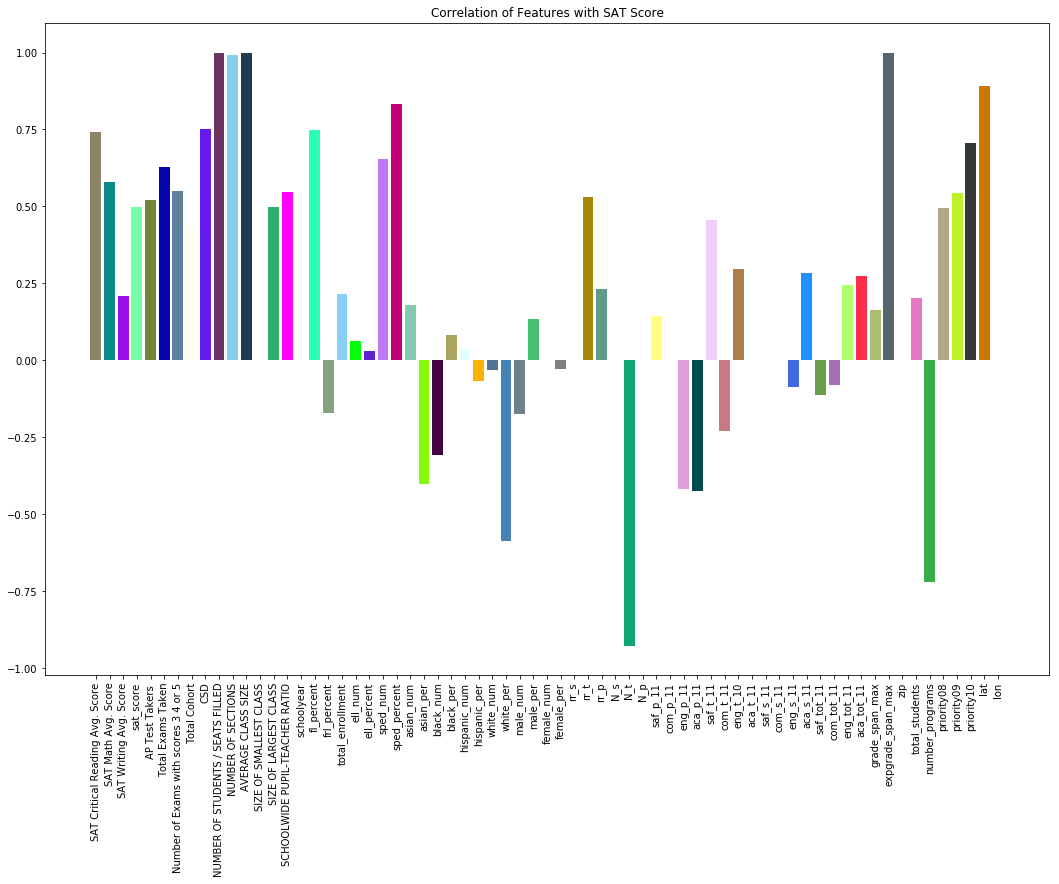

In [15]:
# Preparing a list of colors from matplotlib
colors_list = list(colors._colors_full_map.values())
random.shuffle(colors_list, random.random)

fig, ax = plt.subplots(figsize=(18, 12))
ax.bar(corr_satscore.index, corr_satscore, align='center', color=colors_list)
ax.set_xticklabels(corr_satscore.index, rotation=90)
ax.set_title("Correlation of Features with SAT Score")

plt.show()

### Analyze Effect of Safety on SAT Score

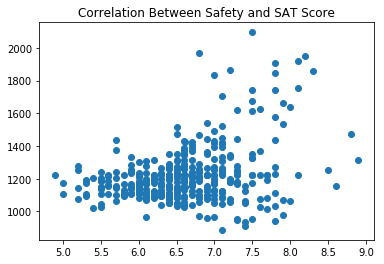

In [16]:
plt.scatter(combined['saf_s_11'], combined['sat_score'])
plt.title("Correlation Between Safety and SAT Score")
plt.show()

There appears to be a positive correlation between safety and SAT score though not so strong. There are some schools that have high safety standard and achieve high SAT score and some schools with low safety standard got low SAT score. Majority of the school from the sample falls between the safety score of 6.0 to 7.5 with an average SAT score below 1500. 

### Map Safety Score by Districts

C:\Users\Yogi_Ashwast\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\Yogi_Ashwast\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


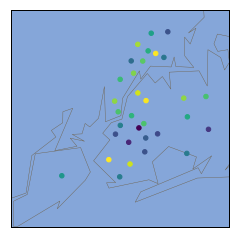

In [17]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

distr = combined.groupby("school_dist").mean()
distr.reset_index(inplace=True)

longitudes = (distr["lon"]).tolist()
latitudes = (distr["lat"]).tolist()
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=distr["saf_s_11"])
plt.show()

Brooklyn seems to have better safety score compared to the same for the parts of Manhattan, Queens and Bronx region.  

### Evaluate Racial Performance in SAT

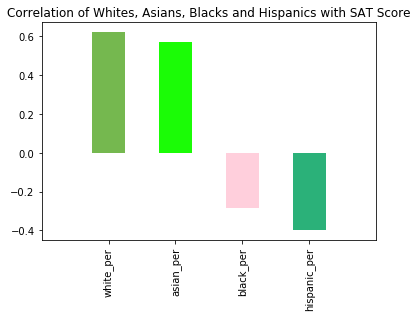

In [18]:
# Listing the races of interest
races = ["white_per", "asian_per", "black_per", "hispanic_per"]
racial_per = combined[races]

# Extracting the coorelation value for the shortlisted races
value_ht = combined.corr()["sat_score"][races]

# Establish plot parameters
x_cor = [1,2,3,4]
random.shuffle(colors_list, random.random)
plt.bar(x_cor, value_ht, width=0.5, align="center", tick_label=races, color=colors_list)
plt.xlim(0,5)
plt.xticks(rotation=90)
plt.title("Correlation of Whites, Asians, Blacks and Hispanics with SAT Score")

plt.show()

The whites and the Asians are found having strong positive correlation while the Blacks and the Hispanic are found having moderate negative correlation with the SAT score. 

This is due to the fact that the Hispanic and the Blacks might be coming from the immigrant families. The socio-economic factors, family support and surrounding environment play significant role in overall performance of the students. 

### Plot Correlation Between Hispanic Proportion & SAT Score

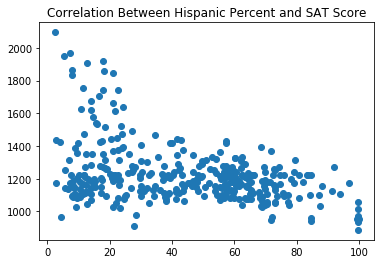

In [19]:
plt.scatter(combined['hispanic_per'], combined['sat_score'])
plt.title("Correlation Between Hispanic Percent and SAT Score")

plt.show()

There seems to be a moderately strong downward trend with the increase of Hispanic Population. Very small portion of population attains a SAT score of 1800 or more while majority falls under the score of 1500. 

### Dependency: Low Sat Score & Hispanic Percent

Correlation Value = -0.41737620009586124


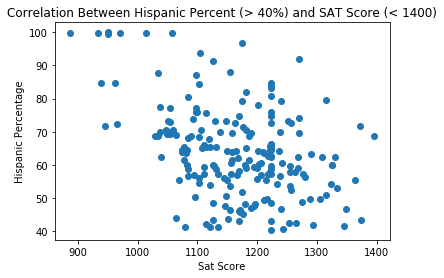

In [20]:
low_sat_high_hisp = combined[combined["sat_score"] < 1400]
low_sat_high_hisp = low_sat_high_hisp[low_sat_high_hisp["hispanic_per"] > 40]
sat_sc = low_sat_high_hisp["sat_score"].values
hisp_per = low_sat_high_hisp["hispanic_per"].values

plt.scatter(sat_sc, hisp_per)
plt.xlabel("Sat Score")
plt.ylabel("Hispanic Percentage")
plt.title("Correlation Between Hispanic Percent (> 40%) and SAT Score (< 1400)")
print("Correlation Value =", low_sat_high_hisp.corr()["sat_score"]["hispanic_per"])

Majority of the schools with Hispanic population in the range of 40% - 80% get average SAT score of around 1150. The results become clearly evident when plotted with 40% or more Hispanic Proportion for SAT score of 1400 or less. 

This is mainly due to the immigrant population along with the socio-economic and demographic factors.

### List Schools with Hispanic More Than 95%

In [21]:
hisp_per_95 = combined[combined["hispanic_per"] > 95]
print(hisp_per_95["SCHOOL NAME"].unique())

['MANHATTAN BRIDGES HIGH SCHOOL'
 'WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL'
 'GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS'
 'ACADEMY FOR LANGUAGE AND TECHNOLOGY'
 'INTERNATIONAL SCHOOL FOR LIBERAL ARTS'
 'PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE'
 'MULTICULTURAL HIGH SCHOOL' 'PAN AMERICAN INTERNATIONAL HIGH SCHOOL']


### List  Schools with Hispanic Less Than 10%

In [22]:
hisp_10_sat_1800 = combined[combined["hispanic_per"] < 10]
hisp_10_sat_1800 = hisp_10_sat_1800[hisp_10_sat_1800["sat_score"] > 1800]
print(hisp_10_sat_1800["SCHOOL NAME"].unique())

['STUYVESANT HIGH SCHOOL' 'BRONX HIGH SCHOOL OF SCIENCE'
 'BROOKLYN TECHNICAL HIGH SCHOOL'
 'QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE'
 'STATEN ISLAND TECHNICAL HIGH SCHOOL']


### Enlist Schools in NYC with Low Total Enrollment and Low SAT Score

In [23]:
# Find the school with low enrolllment that get low SAT score
low_enrollment = combined[(combined['total_enrollment'] < 1000) & (combined['sat_score'] < 1000) ]

# Remove rows with invalid school name
low_enrollment = low_enrollment[low_enrollment['School Name'] != 0]

# Print for verification
low_enrollment['School Name']

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

### Plot Correlation Between Sat Score & Gender

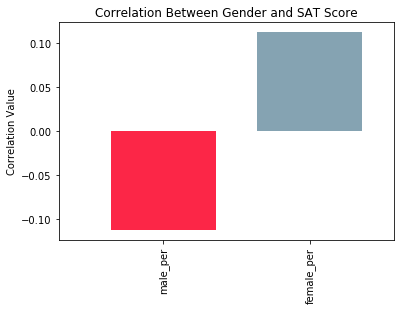

In [24]:
gender = ["male_per", "female_per"]
cor_val = combined.corr()["sat_score"][gender]
x_val = [1, 1.0070]
random.shuffle(colors_list, random.random)

plt.bar(x_val, cor_val, 0.005, align='center', tick_label=gender, color=colors_list)
plt.xlim(0.995,1.011)
plt.ylabel("Correlation Value")
plt.xticks(rotation=90)
plt.title("Correlation Between Gender and SAT Score")
plt.show()

Female show very weak positive and male show very weak negative correlation for SAT score. This shows the relative performance of female and male students – which is more or less the same. 

### High SAT Score & High Female Percentage

Schools with SAT > 1500 & Female > 50% =
 ['NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND MATH HIGH SCHOOL'
 'BARD HIGH SCHOOL EARLY COLLEGE'
 'PROFESSIONAL PERFORMING ARTS HIGH SCHOOL'
 'BARUCH COLLEGE CAMPUS HIGH SCHOOL'
 'N.Y.C. LAB SCHOOL FOR COLLABORATIVE STUDIES'
 'ELEANOR ROOSEVELT HIGH SCHOOL' 'MILLENNIUM HIGH SCHOOL'
 'BEACON HIGH SCHOOL'
 'FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS'
 'LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES'
 'BARD HIGH SCHOOL EARLY COLLEGE II' 'TOWNSEND HARRIS HIGH SCHOOL'
 'BENJAMIN N. CARDOZO HIGH SCHOOL' "SCHOLARS' ACADEMY"
 'QUEENS GATEWAY TO HEALTH SCIENCES SECONDARY SCHOOL'
 'BACCALAUREATE SCHOOL FOR GLOBAL EDUCATION']

Correlation Value between SAT Score and Female Percentage = 0.44951913501293517


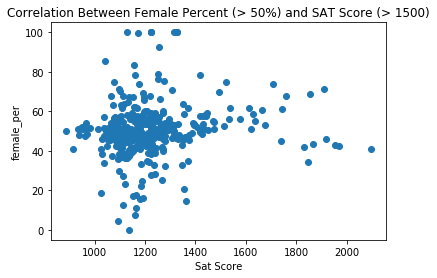

In [25]:
high_sat_n_fem = combined[combined["female_per"] > 50]
high_sat_n_fem = high_sat_n_fem[high_sat_n_fem["sat_score"] > 1500]
print("Schools with SAT > 1500 & Female > 50% =\n", high_sat_n_fem["SCHOOL NAME"].unique())
   
# Plot the scatter diagram 
plt.scatter(combined["sat_score"], combined["female_per"])
plt.xlabel("Sat Score")
plt.ylabel("female_per")
plt.title("Correlation Between Female Percent (> 50%) and SAT Score (> 1500)")

print("\nCorrelation Value between SAT Score and Female Percentage =", high_sat_n_fem.corr()["sat_score"]["female_per"])

There exists moderately positive correlation between the female proportion and SAT score. While tested for pool of students having more than 50% female proportion and SAT score of greater than 1500, it is observed that around 40% - 65% of the total students attain SAT score in the range of 1000 – 1350. 

### SAT Score > 1700 & Female Percentage > 60

In [26]:
fem_60_sat_1700 = combined[(combined["sat_score"] > 1700) & (combined["female_per"] > 60)]
print("Schools with SAT > 1700 & Female > 60% =\n", fem_60_sat_1700["SCHOOL NAME"].unique())

Schools with SAT > 1700 & Female > 60% =
 ['BARD HIGH SCHOOL EARLY COLLEGE' 'ELEANOR ROOSEVELT HIGH SCHOOL'
 'BEACON HIGH SCHOOL'
 'FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS'
 'TOWNSEND HARRIS HIGH SCHOOL']


### Relationship Between AP Test Takers & SAT Score

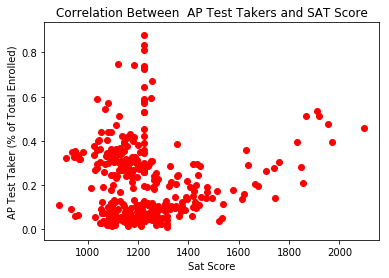

Corrleation value between SAT Score & Percent of AP Test Takers = 0.05717081390766967


In [27]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
plt.scatter(combined["sat_score"], combined["ap_per"], color='r')
plt.xlabel("Sat Score")
plt.ylabel("AP Test Taker (% of Total Enrolled)")
plt.title("Correlation Between  AP Test Takers and SAT Score")
plt.show()

print("Corrleation value between SAT Score & Percent of AP Test Takers =", combined.corr()["sat_score"]["ap_per"])

No correlation is found between the AP Test Takers and the SAT score. In fact, up to 40% of the total enrollment who took AP Test scored less than 1400 in SAT. There are few percent of students who took AP Test and secured SAT score of 1800 – 2000. 

The data about students’ performance in AP Test Vs. SAT could give us more insight to further comment about the AP Test results predictive relevance for SAT score.

### Relationship Between Class Size & SAT Score

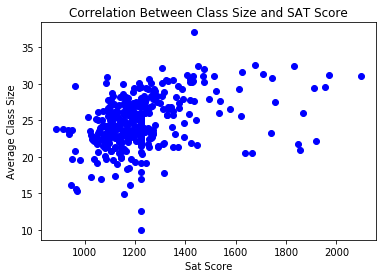

Corrleation value between SAT Score & Average Class Size = 0.3810143308095523


In [28]:
plt.scatter(combined["sat_score"], combined["AVERAGE CLASS SIZE"], color='b')
plt.xlabel("Sat Score")
plt.ylabel("Average Class Size")
plt.title("Correlation Between Class Size and SAT Score")
plt.show()

print("Corrleation value between SAT Score & Average Class Size =", combined.corr()["sat_score"]["AVERAGE CLASS SIZE"])

Moderately strong positive correlation has been observed between the class size and SAT score. Students’ SAT score slowly improves as the class size increases from 20 to 30 students. Majority of the students score between 1000 – 1400 irrespective of class size. However, there are few exceptional cases where the students score beyond 1800.  

This clearly shows that performance of students in SAT is strongly impacted by his/her class size, higher student-teacher ratio and consequently the dense social environment -which collectively proves to be encouraging for the students.  

### Correlation Between Different in Parent, Teacher and Student Responses to Surveys with SAT Score

#### Listing and Cleaning Data

In [29]:
# short listing the relevant columns 
surv_col = ['aca_p_11', 'aca_t_11', 'aca_s_11', 'sat_score']
response = combined[surv_col]

# Cleaning the data with null values
response = response.dropna(axis=0, how='any')

# Making sure no null is left
response.isnull().sum().sum()

0

#### Develop Survey Response Differrence Data

In [30]:
# Developing the survey difference response data
response['aca_p_s'] = (response['aca_p_11'] - response['aca_s_11']).abs()
response['aca_p_t'] = (response['aca_p_11'] - response['aca_t_11']).abs()
response['aca_t_s'] = (response['aca_t_11'] - response['aca_s_11']).abs()

# Plot survey response difference
resp_cols = ['aca_p_s', 'aca_p_t', 'aca_t_s']

# Print for verfication
print(response[resp_cols].head())

    aca_p_s  aca_p_t   aca_t_s
0  0.900000      1.1  0.200000
1  0.300000      0.0  0.300000
2  1.018611      0.4  1.418611
3  0.300000      0.5  0.200000
4  0.700000      1.1  0.400000


#### Correlation Between Parent-Student Survey Difference Response & SAT Score


Correlation between Parent-Student Survey Response & SAT Score = -0.2892526616448787


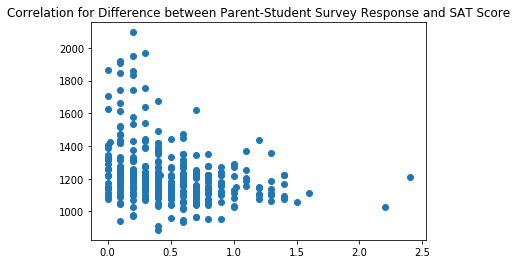

In [31]:
pss_cor0 = response.corr()[resp_cols[0]]["sat_score"]
print("\nCorrelation between Parent-Student Survey Response & SAT Score =", 
      pss_cor0)
plt.scatter(response[resp_cols[0]], response["sat_score"])
plt.title("Correlation for Difference between Parent-Student Survey \
Response and SAT Score")
plt.show()

It appears that there is a moderately strong negative correlation between the difference in Parent-Student Survey Response and SAT Score. Hence, more similarity of parents and student’s opinion about the latter’s academic expectation, better would it be reflected in to the higher SAT score. In other words, more the disparity between parents and student’s responses for students’ academic expectation score, lower would be the SAT score.  

This clearly indicates that parental involvement in student’s education results into a better SAT performance and vice versa. 

#### Correlation Between Parent-Teacher Survey Difference Response & SAT Score


Correlation between Parent-Teacher Survey Response & SAT Score = -0.11002982952218382


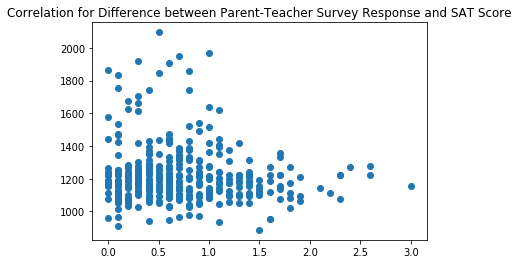

In [32]:
pss_cor1 = response.corr()[resp_cols[1]]["sat_score"]
print("\nCorrelation between Parent-Teacher Survey Response & SAT Score =", 
      pss_cor1)
plt.scatter(response[resp_cols[1]], response["sat_score"])
plt.title("Correlation for Difference between Parent-Teacher Survey \
Response and SAT Score")
plt.show()

There exists weak negative relationship between the difference in parents and teachers’ survey response and SAT score. This indicates that difference of opinion between the parents and the teachers over the expectation of student’s academia has moderately reverse impact over student’s performance in SAT. In other words, less the differences between the parental and teacher’s opinion about student’s academic expectation, moderately better would be student’s performance in SAT. 

#### Correlation Between Teacher-Student Survey Difference Response & SAT Score


Correlation between Teacher-Student Survey Response & SAT Score = -0.09657508196544748


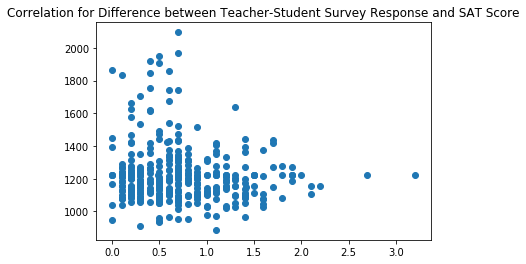

In [33]:
pss_cor2 = response.corr()[resp_cols[2]]["sat_score"]
print("\nCorrelation between Teacher-Student Survey Response & SAT Score =", 
      pss_cor2)                  
plt.scatter(response[resp_cols[2]], response["sat_score"])
plt.title("Correlation for Difference between Teacher-Student Survey \
Response and SAT Score")
plt.show()

No correlation is found between the difference in teachers’ and students’ survey response and SAT score. This indicates that difference of opinion between the teachers and students over the academic expectation for the students have no impact over student’s performance in SAT.

### Find out neighborhoods with Best Schools

#### Determine Top 10 Best School in NYC Based On SAT Score

In [34]:
# Find the top 10 school based on the SAT score
good_schools = combined[combined['sat_score'] > 1750]
good_schools = good_schools.groupby('DBN').agg('max').sort_values(by='sat_score', ascending=False)
good_schools[['boro', 'sat_score', 'SCHOOL NAME', 'CSD', 'zip']].head(10)

,boro,sat_score,SCHOOL NAME,CSD,zip
DBN,,,,,
02M475,Manhattan,2096.0,STUYVESANT HIGH SCHOOL,2,10282
10X445,Bronx,1969.0,BRONX HIGH SCHOOL OF SCIENCE,10,10468
31R605,Staten Island,1953.0,STATEN ISLAND TECHNICAL HIGH SCHOOL,31,10306
10X696,Bronx,1920.0,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,10,10468
25Q525,Queens,1910.0,TOWNSEND HARRIS HIGH SCHOOL,25,11367
28Q687,Queens,1868.0,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,28,11433
01M696,Manhattan,1856.0,BARD HIGH SCHOOL EARLY COLLEGE,1,10002
05M692,Manhattan,1847.0,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",5,10031
13K430,Brooklyn,1833.0,BROOKLYN TECHNICAL HIGH SCHOOL,13,11217


#### Gathering NYC Property Value Information

In [35]:
cols = ['Borough', 'CD', 'SchoolDist', 'ZipCode', 'BldgClass', 'price_sf', 'Address', 'OwnerName']
brk_data = pandas.read_csv(r"databank/nyc_property/BK2017V11.csv", usecols = cols)
brx_data = pandas.read_csv(r"databank/nyc_property/BX2017V11.csv", usecols = cols)
mnh_data = pandas.read_csv(r"databank/nyc_property/MN2017V11.csv", usecols = cols)
qns_data = pandas.read_csv(r"databank/nyc_property/QN2017V11.csv", usecols = cols)
snr_data = pandas.read_csv(r"databank/nyc_property/SI2017V11.csv", usecols = cols)
prop_val = pandas.concat([brk_data, brx_data, mnh_data, qns_data, snr_data], axis=0)

# Print for verification
print(prop_val.shape)
prop_val.head(10)

(53340, 8)


,Borough,CD,SchoolDist,ZipCode,Address,BldgClass,OwnerName,price_sf
0,BK,309,17.0,11213.0,400 UTICA AVENUE,O2,VIS BAN REALTY CORP,50.000000
1,BK,303,13.0,11205.0,117 SANDFORD STREET,G9,117 SANFORD LLC,50.000000
2,BK,301,14.0,11222.0,239 INDIA STREET,O2,INDIA STREET CORP.,50.000000
3,BK,315,21.0,11229.0,1819 EAST 13 STREET,D7,AMK II REALTY LLC,50.000000
4,BK,313,21.0,11224.0,3740 OCEANIC AVENUE,M9,KOZNITZ CONGREGATION,50.000000
5,BK,318,22.0,11210.0,1805 FLATBUSH AVENUE,K4,"MERVEILLE, GLADYS",50.000000
6,BK,307,15.0,11215.0,511 7 AVENUE,W1,DCAS/DEPARTMENT OF ED,50.003959
7,BK,301,14.0,11249.0,58 NORTH 8 STREET,O5,101 KENT ASSOCIATES I,50.008548
8,BK,303,14.0,11205.0,38 SKILLMAN STREET,R4,NaN,50.015724
9,BK,312,21.0,11230.0,1613 MC DONALD AVENUE,E1,CB REALTY COMPANY LLC,50.019231


### Finding Top 10 Cost Effective Properties for NYC School Neighborhood (2 Deals/School)

#### Define functions to seggregate residential class

In [36]:
# Filter data frame for select residential building class 
def usage(char):
    usg = ['A', 'B', 'C', 'D', 'R']
    if char in usg:
        return 1
    else:
        return 0

#### Define Function to Extract Neighborhood  Details

In [37]:
# Define function to extract the neighborhood details
def find_property(data, df):
    sch_dst = data[0]
    zip_code = data[1]
    df = df[(df['ZipCode'] == zip_code) & (df['SchoolDist'] == sch_dst)]
    
    count = 0
    j = 0
    k = 0
    m = df.shape[0]
    inp_vals = [([0] * 5) for i in range(2)]
    
    if (m == 0):
        inp_vals[j][k] = data[3]
        inp_vals[j][k+1] = "No Resi. Property Found"
        inp_vals[j][k+2] = "N/A"
        inp_vals[j][k+3] = "N/A"
        inp_vals[j][k+4] = data[2]
        j += 1
        k = 0
        
    elif (m == 1):
        i = 0
        inp_vals[j][k] = data[3]
        inp_vals[j][k+1] = df['Address'].iloc[i]
        inp_vals[j][k+2] = df['OwnerName'].iloc[i]
        inp_vals[j][k+3] = df['price_sf'].iloc[i]
        inp_vals[j][k+4] = data[2]
        j += 1
        k = 0

    else:
        for i in range(m):
            if (count < 2):
                inp_vals[j][k] = data[3]
                inp_vals[j][k+1] = df['Address'].iloc[i]
                inp_vals[j][k+2] = df['OwnerName'].iloc[i]
                inp_vals[j][k+3] = df['price_sf'].iloc[i]
                inp_vals[j][k+4] = data[2]
                j += 1
                k = 0
                count += 1
            elif (count >= 2):
                break
    return inp_vals

#### Top 10 Cost Effective Neighborhood Properties in NYC for Best Schools (2 choices / school)

In [38]:
# Set up the data frame per ascending property prices, building class and location zip code
sorted_property = prop_val.sort_values(by=['price_sf', 'BldgClass', 'ZipCode'])
sorted_property['ZipCode'] = pandas.to_numeric(sorted_property['ZipCode'], errors = 'coerce')

# Seggregate data based on the building class for residential properties
sorted_property['Usage'] = sorted_property['BldgClass'].str[:1].apply(usage)
sorted_property = sorted_property[sorted_property['Usage'] == 1]

# Removing null values from the data frame
sorted_property = sorted_property.dropna()

# Extracting Top 10 Best Neighbordhood Data
neighbor = [([0]*5) for i in range(20)]
j = 0
for i in range(10):
    first_row, second_row = find_property(good_schools[['CSD', 'zip', 'SCHOOL NAME', 'boro']].iloc[i], sorted_property)
    for k in range(5):
        neighbor[j][k] = first_row[k]
        neighbor[j+1][k] = second_row[k]
    j += 2

# Set up neighbor data frame for output
cols = ['Borough', 'Property Address', 'Owner', 'Price/Sq Ft', 'Neighborhood School']
great_deal = pandas.DataFrame(columns=cols)

# Feed the final output in the data frame
for i in range(len(neighbor)):
        great_deal[cols[0]] = ([x[0] for x in neighbor])
        great_deal[cols[1]] = ([x[1] for x in neighbor])
        great_deal[cols[2]] = ([x[2] for x in neighbor])
        great_deal[cols[3]] = ([x[3] for x in neighbor])
        great_deal[cols[4]] = ([x[4] for x in neighbor])

# Removing data with missing values and resetting the index
great_deal = great_deal[great_deal['Borough'] != 0]
great_deal.reset_index(inplace=True, drop=True)

# Print the final results results
print("\nList of Least Expensive Neighborhood With Great Schools: \n")
great_deal


List of Least Expensive Neighborhood With Great Schools: 



,Borough,Property Address,Owner,Price/Sq Ft,Neighborhood School
0,Manhattan,201 WARREN STREET,TRIBECA NORTH END LLC,112.479,STUYVESANT HIGH SCHOOL
1,Manhattan,399 CHAMBERS STREET,TRIBECA POINTE LLC,114.277,STUYVESANT HIGH SCHOOL
2,Bronx,2450 DAVIDSON AVENUE,2460 DAVIDSON REALTY,51.4895,BRONX HIGH SCHOOL OF SCIENCE
3,Bronx,2776 SEDGWICK AVENUE,"TINEO, JOSE RAMON",51.8865,BRONX HIGH SCHOOL OF SCIENCE
4,Staten Island,10 PEEL PLACE,ANN SOLAZZO,24.215,STATEN ISLAND TECHNICAL HIGH SCHOOL
5,Staten Island,41 PETER AVENUE,"SCAROLA, GREGG M",24.2163,STATEN ISLAND TECHNICAL HIGH SCHOOL
6,Bronx,2450 DAVIDSON AVENUE,2460 DAVIDSON REALTY,51.4895,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
7,Bronx,2776 SEDGWICK AVENUE,"TINEO, JOSE RAMON",51.8865,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
8,Queens,152-11 UNION TURNPIKE,ST. JOHN'S UNIVERSITY,50.8769,TOWNSEND HARRIS HIGH SCHOOL
9,Queens,154-27 64 AVENUE,WISCHHUSEN RICHARD,66.6693,TOWNSEND HARRIS HIGH SCHOOL


### Conclusion